In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(n, k, max_m_value):
    input_shape = (k, n - k)  
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Transpose so we can treat each column independently
    # After transpose: shape becomes (batch_size, n-k, k)
    transposed = layers.Permute((2, 1))(input_layer)  

    # Shared MLP applied to each column (like DeepSets)
    shared_mlp = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu')
    ])

    # Apply shared MLP to each column (TimeDistributed over n-k columns)
    encoded_columns = layers.TimeDistributed(shared_mlp)(transposed)  # (batch, n-k, 64)

    # Aggregate over columns to achieve permutation invariance
    aggregated = layers.GlobalAveragePooling1D()(encoded_columns)  # (batch, 64)

    # Final prediction head
    output_layer = layers.Dense(max_m_value, activation='linear')(aggregated)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model

2025-04-04 23:13:06.048125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743826386.093492   10336 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743826386.104037   10336 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743826386.147678   10336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743826386.147701   10336 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743826386.147703   10336 computation_placer.cc:177] computation placer alr

In [2]:
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [14]:
class CustomModel:
    def __init__(self, n, k, max_m_value):
        self.n = n
        self.k = k
        self.max_m_value = max_m_value

        self.P_matrices = None
        self.m_heights = None
        self.P_matrices_train = None 
        self.P_matrices_test = None 
        self.P_matrices_val = None
        self.m_heights_train = None 
        self.m_heights_test = None
        self.m_heights_log_train = None
        self.m_heights_log_test = None   
        self.m_heights_log_val = None
        self.eval_inputs = None
        self.eval_outputs = None
        self.P_matrices_train_aug = None
        self.m_heights_log_train_aug = None

        self.train_dataset = None
        self.val_dataset = None

        self.model_name = f'model_{n}_{k}.keras'
        self.model = None
        self.history = None
    def load_and_preprocess_data(self,filepath):
        with gzip.open(filepath, 'rb') as f:
            dataset = pickle.load(f)

        self.P_matrices = []
        self.m_heights = []

        for row in dataset:
            # Remove the last `inf`, this is an error due to bug in the dataset generation
            heights = row['m_heights'][:-1]  
            if len(heights) != self.max_m_value:
                continue
            if any(h == float('inf') or h <= 0 for h in heights):
                continue
            # Convert m-heights to log scale
            log_heights = np.log(heights)
            P_matrix = np.array(row['P_matrix'], dtype=np.float32)

            self.P_matrices.append(P_matrix)
            # m_heights.append(log_heights)
            self.m_heights.append(heights)
        self.P_matrices = np.array(self.P_matrices, dtype=np.float32)
        self.m_heights = np.array(self.m_heights, dtype=np.float32)
        print("P_matrices shape:", self.P_matrices.shape)
        print("m_heights shape:", self.m_heights.shape)
        # pritnt range of all m-heights 
        print("Range of log m_heights:")
        print("Min:", np.min(self.m_heights, axis=0))
        print("Max:", np.max(self.m_heights, axis=0))
            
    def generate_permuted_dataset(self, P_matrices, m_heights, num_permutations=3):
        """Create augmented dataset by permuting columns of P_matrices."""
        augmented_P_matrices = []
        augmented_m_heights = []

        for i in range(len(P_matrices)):
            original = P_matrices[i]
            target = m_heights[i]

            # Keep original
            augmented_P_matrices.append(original)
            augmented_m_heights.append(target)

            # Generate random permutations
            for _ in range(num_permutations):
                permuted = original[:, np.random.permutation(original.shape[1])]
                augmented_P_matrices.append(permuted)
                augmented_m_heights.append(target)
        return np.array(augmented_P_matrices), np.array(augmented_m_heights)
    def train_test_val_split(self, val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342):
        
        if(self.P_matrices is None or self.m_heights is None):
            raise ValueError("Data not loaded. Please load the data first.")
        # Train-test split
        self.P_matrices_train, self.P_matrices_test,\
              self.m_heights_train, self.m_heights_test\
                 = train_test_split(self.P_matrices, self.m_heights, test_size=test_split, random_state=random_state)

        # Converting test set to evaluator format
        self.eval_inputs = {}
        self.eval_outputs = {}

        # Iterate through each P_matrix and corresponding m_heights in test_dataset
        for i in range(len(self.P_matrices_test)):
            P_matrix = self.P_matrices_test[i]
            m_heights_list = self.m_heights_test[i]
            for m in range(2, self.max_m_value + 1):  # m ranges from 2 to max_m_value
                key = f"[{self.n},{self.k},{m}]"
                
                # Add the P_matrix to the inputs dictionary
                if key not in self.eval_inputs:
                    self.eval_inputs[key] = []
                self.eval_inputs[key].append(P_matrix)
                
                # Add the corresponding m_height to the outputs dictionary
                if key not in self.eval_outputs:
                    self.eval_outputs[key] = []
                self.eval_outputs[key].append(m_heights_list[m - 1])  # m-1 to get the correct index

        # Change m_heights_train and m_heights_test to log_scale
        self.m_heights_log_train = np.log(self.m_heights_train)
        self.m_heights_log_test = np.log(self.m_heights_test)

        # Train-validation split
        self.P_matrices_train, self.P_matrices_val, self.m_heights_log_train, self.m_heights_log_val = train_test_split(self.P_matrices_train, self.m_heights_log_train, test_size=val_split, random_state=random_state)
        # Generate augmented  training dataset
        self.P_matrices_train_aug, self.m_heights_log_train_aug = self.generate_permuted_dataset(self.P_matrices_train, self.m_heights_log_train, num_permutations=num_permutations) 
        # Create TensorFlow datasets
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_log_train_aug))
        self.train_dataset = self.train_dataset.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_log_val))
        self.val_dataset = self.val_dataset.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        print("Train dataset shape:", self.P_matrices_train_aug.shape, self.m_heights_log_train_aug.shape)
        print("Validation dataset shape:", self.P_matrices_val.shape, self.m_heights_log_val.shape)
        print("Test dataset shape:", self.P_matrices_test.shape, self.m_heights_log_test.shape)
    
    def model_compile(self, build_model, print_summary=False):
        if self.train_dataset is None or self.val_dataset is None:
            raise ValueError("Train and validation datasets not created. Please create them first.")
        self.model = build_model(self.n, self.k, self.max_m_value)
        print("Model compiled.")
        if print_summary:
            self.model.summary()
    
    def model_train(self, epochs=10, verbose=0, patience=5):
        if self.model is None:
            raise ValueError("Model not built. Please build the model first.")
        
        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(self.model_name, save_best_only=True)
        # Train the model
        self.history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[
                early_stopping,
                model_checkpoint,
            ],
            verbose=verbose
        )
    def plot_history(self):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        history_dict = self.history.history
        mse = history_dict["loss"]
        val_mse = history_dict["val_loss"]
        epochs = range(1, len(mse) + 1)
        print('Train MSE :', mse)
        print('Validation MSE :', val_mse)
        plt.plot(epochs, mse, "bo", label="Training mse")
        plt.plot(epochs, val_mse, "b", label="Validation mse")
        plt.title("Training and validation mean squared error")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
    def evaluate_model(self, batch_size=128):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        results = self.model.evaluate(self.P_matrices_test, self.m_heights_log_test, batch_size=batch_size, verbose=0)
        print('Best model loss :', results)
    

In [41]:
filepath= "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/G_9_4_maxM5.pklgz"
model_9_4 = CustomModel(n=9, k=4, max_m_value=5)
model_9_4.load_and_preprocess_data(filepath)

P_matrices shape: (34999, 4, 5)
m_heights shape: (34999, 5)
Range of log m_heights:
Min: [   3.3710756    8.660064    75.08341    182.32542   1253.2301   ]
Max: [2.7675543e+02 7.5315314e+02 4.8695015e+03 2.2775238e+05 7.9118080e+08]


In [42]:
model_9_4.train_test_val_split(val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342)

Train dataset shape: (111995, 4, 5) (111995, 5)
Validation dataset shape: (5600, 4, 5) (5600, 5)
Test dataset shape: (7000, 4, 5) (7000, 5)


In [43]:
model_9_4.model_compile(build_model, print_summary=True)

Model compiled.


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 4, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_3 (Permute)             │ (None, 5, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 5, 64)          │         4,480 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,805 (18.77 KB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
model_9_4.model_train(epochs=30, verbose=1, patience=5)

Epoch 1/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 7.4650 - val_loss: 1.0088
Epoch 2/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9628 - val_loss: 0.9000
Epoch 3/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.8594 - val_loss: 0.7958
Epoch 4/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7709 - val_loss: 0.7157
Epoch 5/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.6998 - val_loss: 0.6625
Epoch 6/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6544 - val_loss: 0.6283
Epoch 7/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6296 - val_loss: 0.6522
Epoch 8/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6188 - val_loss: 0.6227
Epoch 9/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.6202 - val_loss: 0.6204
Epoch 10/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6072 - val_loss: 0.6082
Epoch 11/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.6092 - val_loss: 0.6556
Epoch 12/30
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Train MSE : [2.3600683212280273, 0.9286287426948547, 0.8368867635726929, 0.7547671794891357, 0.6852201819419861, 0.6466768383979797, 0.6267961859703064, 0.620735764503479, 0.6151325702667236, 0.6102592349052429, 0.6076390743255615, 0.6072209477424622, 0.6015505194664001, 0.5999023914337158, 0.6015544533729553, 0.5962674021720886, 0.5951195359230042, 0.595492422580719, 0.5938342809677124]
Validation MSE : [1.0088223218917847, 0.9000166654586792, 0.7957763671875, 0.7157384157180786, 0.6625100374221802, 0.6283418536186218, 0.6521666646003723, 0.6226512789726257, 0.620424211025238, 0.608198881149292, 0.655620813369751, 0.6016947031021118, 0.6120434403419495, 0.5898231863975525, 0.6260702610015869, 0.5947109460830688, 0.594819962978363, 0.594072699546814, 0.5987779498100281]


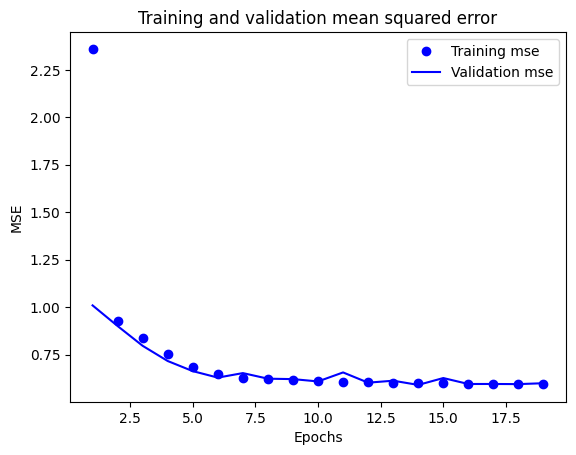

Best model loss : 0.5948461890220642


In [46]:
model_9_4.plot_history()
model_9_4.evaluate_model(batch_size=128)

In [47]:
filepath= "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/G_9_5_maxM4.pklgz"
model_9_5 = CustomModel(n=9, k=5, max_m_value=4)
model_9_5.load_and_preprocess_data(filepath)

P_matrices shape: (59992, 5, 4)
m_heights shape: (59992, 4)
Range of log m_heights:
Min: [   6.3078012   59.612354   217.01117   1291.7003   ]
Max: [4.2418826e+02 5.4309243e+03 4.0550069e+05 2.9340678e+08]


In [48]:
model_9_5.train_test_val_split(val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342)

Train dataset shape: (191970, 5, 4) (191970, 4)
Validation dataset shape: (9599, 5, 4) (9599, 4)
Test dataset shape: (11999, 5, 4) (11999, 4)


In [49]:
model_9_5.model_compile(build_model, print_summary=True)

Model compiled.


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 5, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ permute_4 (Permute)             │ (None, 4, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 64)          │         4,544 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,804 (18.77 KB)

 Trainable params: 4,804 (18.77 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
model_9_5.model_train(epochs=30, verbose=1, patience=5)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 4.5970 - val_loss: 0.9838
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.9375 - val_loss: 0.8251
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.7697 - val_loss: 0.6879
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6603 - val_loss: 0.6256
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.6236 - val_loss: 0.6278
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6141 - val_loss: 0.6080
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.6020 - val_loss: 0.5996
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.5952 - val_loss: 0.5982
Epoch 9/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.5947 - val_loss: 0.5959
Epoch 10/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.5900 - val_loss: 0.5999
Epoch 11/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.5890 - val_loss: 0.5863
Epoch 12/30
1500/1500 ━━━━━━━

Train MSE : [1.8510109186172485, 0.8897569179534912, 0.7390426397323608, 0.653509259223938, 0.6217973232269287, 0.6090213656425476, 0.6009571552276611, 0.5975359082221985, 0.5926785469055176, 0.5920372605323792, 0.5891092419624329, 0.5884543061256409, 0.5843445062637329, 0.5841807126998901, 0.5819243788719177, 0.5800101161003113, 0.5792043805122375, 0.5782086253166199, 0.5762202143669128, 0.57583087682724, 0.5742664933204651, 0.5737632513046265, 0.572267472743988, 0.5714603662490845, 0.5700344443321228, 0.569582462310791, 0.5687071084976196, 0.5677919387817383, 0.5671120882034302, 0.5666723847389221]
Validation MSE : [0.9838311076164246, 0.8250546455383301, 0.6879370808601379, 0.6256443858146667, 0.6277950406074524, 0.6080271601676941, 0.5996489524841309, 0.5981540083885193, 0.5958730578422546, 0.5998858213424683, 0.586263120174408, 0.5892615914344788, 0.6276755928993225, 0.598124623298645, 0.5854795575141907, 0.5903620719909668, 0.5820512771606445, 0.5888900756835938, 0.58663213253021

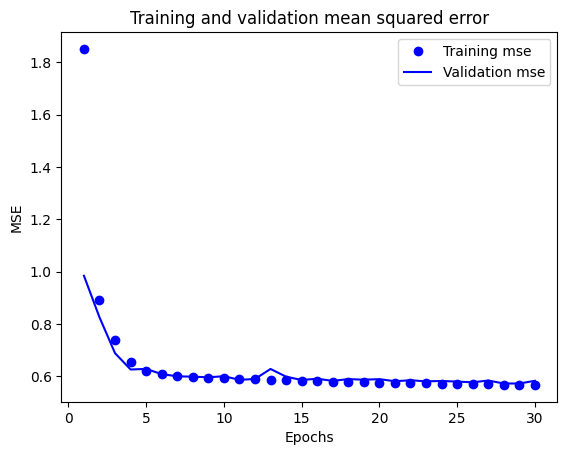

Best model loss : 0.5649280548095703


In [51]:
model_9_5.plot_history()
model_9_5.evaluate_model(batch_size=128)

In [9]:
from tamu_csce_636_project1 import Evaluator
evaluator = Evaluator(
    first_name="Your Name",
    last_name="Your Name",
    email="email@tamu.edu",
    print=False,
)

In [10]:
def predict_and_evaluate(n,k,m,P_matrices):
    ## load model
    model_name = f'model_{n}_{k}.keras'
    model = tf.keras.models.load_model(model_name)
    m_heights = []
    P_matrices = np.array(P_matrices, dtype=np.float32)
    m_heights_pred = model.predict(P_matrices.reshape(len(P_matrices), k, n-k), verbose=0)
    m_heights =[np.exp(m_heights_pred[i][m-1]) for i in range(len(P_matrices))]
    # print(P_matrices[0])
    # print(m_heights_pred[0])
    # print(m_heights_pred[0][m-1])
    # print(np.exp(m_heights_pred[0][m-1]))
    # print(m_heights[0])
    return m_heights

In [36]:
σ = evaluator.eval(
    inputs=model_9_4.eval_inputs,
    outputs=model_9_4.eval_outputs,
    func=predict_and_evaluate,
)
print("σ:", σ)

σ: defaultdict(<function Evaluator.eval.<locals>.<lambda> at 0x7f9f6f3e5760>, {(9, 4, 2): 0.18543618600302486, (9, 4, 3): 0.22250887292365357, (9, 4, 4): 0.8153108420859081, (9, 4, 5): 3.442779723837407})


In [52]:
σ = evaluator.eval(
    inputs=model_9_5.eval_inputs,
    outputs=model_9_5.eval_outputs,
    func=predict_and_evaluate,
)
print("σ:", σ)

σ: defaultdict(<function Evaluator.eval.<locals>.<lambda> at 0x7f9f6f8bd300>, {(9, 5, 2): 0.21212121455433483, (9, 5, 3): 0.788908816751541, (9, 5, 4): 3.393564808842936})


In [17]:
models_dict =  {
    "model_1": {'n': 9, 'k': 4, 'max_m_value': 5, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_2": {'n': 9, 'k': 5, 'max_m_value': 4, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_3": {'n': 9, 'k': 6, 'max_m_value': 3, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},
    "model_4": {'n': 10, 'k': 4, 'max_m_value': 6, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_5": {'n': 10, 'k': 5, 'max_m_value': 5, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_6": {'n': 10, 'k': 6, 'max_m_value': 6, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
}

Loading data for model_9_4...
P_matrices shape: (34999, 4, 5)
m_heights shape: (34999, 5)
Range of log m_heights:
Min: [   3.3710756    8.660064    75.08341    182.32542   1253.2301   ]
Max: [2.7675543e+02 7.5315314e+02 4.8695015e+03 2.2775238e+05 7.9118080e+08]
Generating dataset for model_9_4...
Train dataset shape: (111995, 4, 5) (111995, 5)
Validation dataset shape: (5600, 4, 5) (5600, 5)
Test dataset shape: (7000, 4, 5) (7000, 5)
Compiling model for model_9_4...
Model compiled.
Training model for model_9_4...
Evaluating model for model_9_4...
Train MSE : [3.479238510131836, 0.9697700142860413, 0.8824591636657715, 0.8165178298950195, 0.7465223073959351, 0.6878271102905273, 0.6475480794906616, 0.6262642741203308, 0.6211437582969666, 0.6127335429191589, 0.6091058850288391, 0.6054422855377197, 0.603011429309845, 0.6016635894775391, 0.5984802842140198, 0.5975146889686584, 0.5971806049346924, 0.5949608683586121, 0.5937476754188538, 0.5927119255065918, 0.5921145081520081, 0.5912352204322

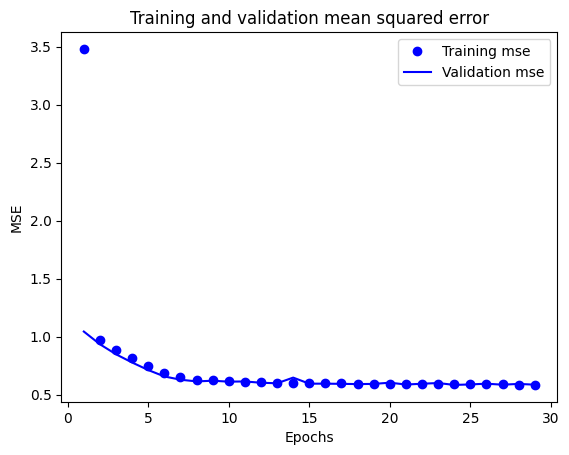

Best model loss : 0.5841917991638184
Done with model_9_4.
-----------------------------------------------------
Loading data for model_9_5...
P_matrices shape: (59992, 5, 4)
m_heights shape: (59992, 4)
Range of log m_heights:
Min: [   6.3078012   59.612354   217.01117   1291.7003   ]
Max: [4.2418826e+02 5.4309243e+03 4.0550069e+05 2.9340678e+08]
Generating dataset for model_9_5...
Train dataset shape: (191970, 5, 4) (191970, 4)
Validation dataset shape: (9599, 5, 4) (9599, 4)
Test dataset shape: (11999, 5, 4) (11999, 4)
Compiling model for model_9_5...
Model compiled.
Training model for model_9_5...


In [ ]:
val_split = 0.2
test_split = 0.2
num_permutations = 4
batch_size = 128
random_state = 2342
epochs = 30
patience = 5
train_verbosity = 0
for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    filepath = "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/" + model_info['file_name']
    n = model_info['n']
    k = model_info['k']
    max_m_value = model_info['max_m_value']
    model_info['model'] = CustomModel(n=n, k=k, max_m_value=max_m_value)
    print(f"Loading data for model_{n}_{k}...")
    model_info['model'].load_and_preprocess_data(filepath)
    print(f"Generating dataset for model_{n}_{k}...")
    model_info['model'].train_test_val_split(val_split=val_split, test_split=test_split, num_permutations=num_permutations, batch_size=batch_size, random_state=random_state)
    print(f"Compiling model for model_{n}_{k}...")
    model_info['model'].model_compile(build_model, print_summary=False)
    print(f"Training model for model_{n}_{k}...")
    model_info['model'].model_train(epochs=epochs, verbose=train_verbosity, patience=patience)
    print(f"Evaluating model for model_{n}_{k}...")
    model_info['model'].plot_history()
    model_info['model'].evaluate_model(batch_size=batch_size)
    print(f"Done with model_{n}_{k}.")
    print("-----------------------------------------------------")
    

In [ ]:
for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    σ = evaluator.eval(
        inputs=model_info['model'].eval_inputs,
        outputs=model_info['model'].eval_outputs,
        func=predict_and_evaluate,
    )
    print(f"σ for {model_name}:", σ)

AttributeError: 'NoneType' object has no attribute 'eval_inputs'